# Random Forests Classifier ROC curve and other analysis

In [82]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix
from sklearn.metrics import f1_score, make_scorer, matthews_corrcoef, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle

%matplotlib inline

## Import  and normalize data

In [83]:
NUMBER_OF_IMGS = 410
NUMBER_OF_MASSES = 107

file_path = "feature-tables/train-data_1526424532.csv"
data = pd.read_csv(file_path)

# average number of ROIs per image
# we need to do simple averaging since mass images have fprs as well
reg_per_img = len(data)/(NUMBER_OF_IMGS)
print(reg_per_img)

data.sample(5)

15.551219512195122


,Unnamed: 0,perimeter,area,circularity,ac,shape_factor,mean_intensity,standard_deviation,smoothness,skewness,kurtosis,correlation,contrast,uniformity,homogeneity,energy,dissimilarity,class_id
1555,1555,4867.158503,96940.5,19.446250,4985.048587,244.368782,32888.949183,18895.607594,1.0,-2.676903e+10,2.301411e+17,0.653724,222.752560,0.464620,0.698723,0.681631,6.881463,-1.0
237,237,410.284271,4659.0,2.875194,1620.412371,36.130754,33357.984160,18942.678632,1.0,-3.231509e+11,2.317281e+17,0.549788,399.545633,0.190706,0.467533,0.436699,12.218299,-1.0
1071,1071,276.727922,2587.5,2.355135,1098.663300,29.595495,32588.944954,18926.476180,1.0,1.279175e+11,2.317954e+17,0.528307,410.519186,0.172922,0.443970,0.415839,12.642993,-1.0
1090,1090,1993.705624,31276.0,10.113489,3092.503536,127.089849,33085.813141,18890.106201,1.0,6.374798e+10,2.299846e+17,0.673157,189.643192,0.529190,0.742418,0.727454,5.870941,-1.0
2257,2257,723.396969,9294.0,4.480648,2074.253499,56.305485,33449.799337,18908.202299,1.0,-1.076505e+11,2.293764e+17,0.626265,291.988508,0.339795,0.605288,0.582919,9.008491,-1.0


In [136]:
#specify feature and target
Feature = data.drop(['class_id', 'Unnamed: 0'], axis=1)
Target  = data['class_id']

# shuffle the dataset
X = Feature.as_matrix()
y = Target.as_matrix()
X, y = shuffle(X, y, random_state=None)

#standardize data (mean = 0)
X = preprocessing.robust_scale(X)

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

print(y_train.shape)
print(y_test.shape)

(3188,)
(3188,)


## Classifier with manually selected parameters

### Training

In [143]:
# 85% of masses detected, 85% accuracy, f1_score=20%, mathew_coef=25%
# Parameter selection by me
clf_me = RandomForestClassifier(n_estimators=500,
                             max_features='sqrt',
                             min_samples_leaf=50,
                             class_weight='balanced',
                             oob_score=True)

# Fit the best algorithm to the data. 
clf_me.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=50,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

### Analysis

In [144]:
prob_me = clf_me.predict_proba(X_test)
pred_me = clf_me.predict(X_test)

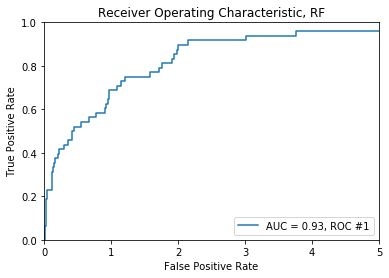

In [196]:
# for parameters selected by me
def get_roc(test_labels, out_probs):
    
    if (not isinstance(test_labels, list)) and (not isinstance(test_labels, tuple)):
        test_labels = (test_labels,)
    
    if (not isinstance(out_probs, list)) and (not isinstance(out_probs, tuple)):
        out_probs = (out_probs,)
        
    for i, labels_probs in enumerate(zip(test_labels, out_probs)):
        test_ls, out_prob = labels_probs
        fpr, tpr, _ = roc_curve(test_ls, out_prob[:,1], pos_label=1, drop_intermediate=True)
        roc_auc = auc(fpr, tpr)

        plt.title('Receiver Operating Characteristic, RF')
        fp = fpr * reg_per_img
        plt.plot(fp, tpr, label=f'AUC = {roc_auc:.2f}, ROC #{i+1}')
        plt.legend(loc='lower right')
    
    plt.xlim([-0,5])
    plt.ylim([-0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


get_roc(y_test, prob_me)

In [200]:
# Runs the classifier and outputs the metrics
def metrics_report(labels, predictions):
    print(f'Number of masses {sum(labels > 0)}')
    print(f'Number of non-masses {sum(labels < 0)}')
    print('Confusion matrix:')
    print(confusion_matrix(labels, predictions, labels=[1,-1]),'\n')
    print('Classification report:')
    print(classification_report(labels, predictions, labels=[1,-1]),'\n')
    print('Accuracy:')
    print(accuracy_score(labels, predictions),'\n')
    print('Matthew Correlation Coefficient:')
    print(matthews_corrcoef(labels, predictions),'\n')


metrics_report(y_test, pred_me)

Number of masses 48
Number of non-masses 3140
Confusion matrix:
[[  37   11]
 [ 337 2803]] 

Classification report:
             precision    recall  f1-score   support

          1       0.10      0.77      0.18        48
         -1       1.00      0.89      0.94      3140

avg / total       0.98      0.89      0.93      3188
 

Accuracy:
0.890840652446675 

Matthew Correlation Coefficient:
0.25109269674703283 



In [121]:
# Validate with k-fold
def run_kfold(clf):
    kf = KFold(891, n_folds=10)
    acc_outcomes = []
    f1_outcomes = []
    mat_outcomes = []
    fold = 0
    
    for train_index, test_index in kf:
        fold += 1
        X_train, X_test = Feature.values[train_index], Feature.values[test_index]
        y_train, y_test = Target.values[train_index], Target.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        f1 = f1_score(y_test, predictions)
        mat_coef = matthews_corrcoef(y_test, predictions)
        acc_outcomes.append(accuracy)
        f1_outcomes.append(f1)
        mat_outcomes.append(mat_coef)
        #print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_acc_outcome = np.mean(acc_outcomes)
    mean_f1_outcome = np.mean(f1_outcomes)
    mean_mat_outcome = np.mean(mat_outcomes)
    print("Mean Accuracy: {0}".format(mean_acc_outcome))
    print("Mean F1 Score: {0}".format(mean_f1_outcome))
    print("Mean Matthew Correlation coefficient: {0}".format(mean_mat_outcome)) 

run_kfold(clf_me)

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Mean Accuracy: 0.8676654182272159
Mean F1 Score: 0.19699211263452748
Mean Matthew Correlation coefficient: 0.23079418863940865


## Optimized parameters by GridSerachCV

## Training

In [138]:
# Parameter selection based on GridSearchCV masses 51%,, accuracy=97%, f1_score=20%, mather_coef=18%
clf_opt_train = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=16, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=35, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

# Fit to the data. 
clf_opt_train.fit(X_train, y_train)

clf_opt_test = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=16, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=35, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

clf_opt_test.fit(X_test, y_test)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=16, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=35, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

### Analysis

In [197]:
prob_opt_train = clf_opt_train.predict_proba(X_test)
pred_opt_train = clf_opt_train.predict(X_test)

prob_opt_test = clf_opt.predict_proba(X_train)
pred_opt_test = clf_opt.predict(X_train)

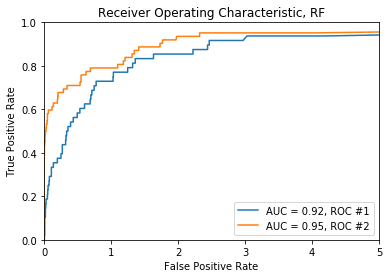

In [199]:
labels = (y_test, y_train, )
probs = (prob_opt_train, prob_opt_test, )

get_roc(labels, probs)

In [201]:
metrics_report(y_test, pred_opt_train)

Number of masses 48
Number of non-masses 3140
Confusion matrix:
[[  17   31]
 [  34 3106]] 

Classification report:
             precision    recall  f1-score   support

          1       0.33      0.35      0.34        48
         -1       0.99      0.99      0.99      3140

avg / total       0.98      0.98      0.98      3188
 

Accuracy:
0.9796110414052698 

Matthew Correlation Coefficient:
0.3332466400566431 



In [49]:
run_kfold(clf_opt)

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encounte

Mean Accuracy: 0.9708863920099875
Mean F1 Score: 0.25666666666666665
Mean Matthew Correlation coefficient: 0.27050316908583305
